### This notebook is used to evaluate the adversarial examples generated by each attack methods. 

In [17]:
import pandas as pd
from tqdm import notebook as tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import tensorflow as tf
import tensorflow_hub as hub
import torch
import math
import numpy as np

In [18]:
PYTORCH_DEVICE = 0
TF_DEVICE = 1
torch.cuda.set_device(0)

`GPT2Metric` measures the percent difference is perplexities of original text $x$ and adversarial example $x_{adv}$.

`USEMetric` measures the Universal Sentence Encoder similarity between $x$ and $x_{adv}$.

`PercentageOfWordsChanged`: measures the percentage of words swapped in $x$ to produce $x_{adv}$. 

`Evaluator`: evaluator runs all three metrics for each sample and reports the average.

In [19]:
class GPT2Metric:
    def __init__(self):
        self._model = AutoModelForCausalLM.from_pretrained("gpt2")
        self._model.to(device=f'cuda:{PYTORCH_DEVICE}')
        self._tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
        
    def perplexity(self, text):
        input_ids = self._tokenizer.encode(text)
        input_ids = input_ids[: self._tokenizer.model_max_length - 2]
        input_ids.insert(0, self._tokenizer.bos_token_id)
        input_ids.append(self._tokenizer.eos_token_id)
        input_ids = torch.tensor(input_ids)
        input_ids = input_ids.to(device=f'cuda:{PYTORCH_DEVICE}')
        with torch.no_grad():
            loss = self._model(input_ids, labels=input_ids)[0].item()
    
        perplexity = math.exp(loss)
        return perplexity
    
    def calc_metric(self, orig_text, new_text):
        orig_perplexity = self.perplexity(orig_text)
        new_perplexity = self.perplexity(new_text)
        return (new_perplexity - orig_perplexity) / orig_perplexity
    

class USEMetric:
    def __init__(self):
        tfhub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
        with tf.device(f'/device:GPU:{TF_DEVICE}'):
            self._model = hub.load(tfhub_url)

    def encode(self, orig_text, new_text):
        with tf.device(f'/device:GPU:{TF_DEVICE}'):
            return self._model([orig_text, new_text]).numpy()
    
    def get_angular_sim(self, emb1, emb2):
        cos_sim = torch.nn.CosineSimilarity(dim=0)(emb1, emb2)
        return 1 - (torch.acos(cos_sim) / math.pi)
    
    def calc_metric(self, orig_text, new_text):
        orig_emb, new_emb = self.encode(orig_text, new_text)
        orig_emb = torch.tensor(orig_emb)
        new_emb = torch.tensor(new_emb)
        sim = self.get_angular_sim(orig_emb, new_emb).item()
        return sim

class PercentageOfWordsChanged:
    def calc_metric(self, orig_text, new_text):
        orig_words = np.array(orig_text.split())
        new_words = np.array(new_text.split())
        words_changed = (orig_words != new_words).sum()
        return words_changed * 100 / len(orig_words)
    
class Evaluator:
    def __init__(self):
        self.use_metric = USEMetric()
        self.gpt2_metric = GPT2Metric()
        self.percentageOfWordsChanged = PercentageOfWordsChanged()
        
    def evaluate(self, csv_file, all_successful):
        df = pd.read_csv(csv_file)
        df = df[df['result_type']=="Successful"]

        total_sim = 0
        total_pp_diff = 0
        word_changed_percent = 0
        N = 0
        for i, row in df.iterrows():
            original_text = row["original_text"].replace("[","").replace("]","")
            if original_text not in all_successful:
                continue
            perturbed_text = row["perturbed_text"].replace("[","").replace("]","")
            sim = self.use_metric.calc_metric(original_text, perturbed_text)
            total_sim += sim
            pp_diff = self.gpt2_metric.calc_metric(original_text, perturbed_text)
            total_pp_diff += pp_diff
            word_changed_percent += self.percentageOfWordsChanged.calc_metric(original_text, perturbed_text)
            N += 1

        return total_sim / N, total_pp_diff / N, word_changed_percent / N

In [20]:
evaluator = Evaluator()

/home/heliya/micromamba/envs/master/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
models = ["bert-yelp-test", "bert-mr-test", "bert-snli-test", "lstm-yelp-test", "lstm-mr-test"]
model_dataset_names = {
    "bert-mr-test": "BERT Movie Reviews",
    "bert-yelp-test": "BERT Yelp Polarity",
    "lstm-mr-test": "LSTM Movie Reviews",
    "lstm-yelp-test": "LSTM Yelp Polarity",
}
transformations = ["word-swap-embedding", "word-swap-hownet", "word-swap-wordnet"]
constraint_levels = ["strict"]
search_methods = ["tabu2",
                  "tabu4",
                  "tabu8",
                  "tabu_agglomerative_average",
                  "tabu_agglomerative_complete",
                  "tabu_agglomerative_single",
                  "tabu_agglomerative_ward",
                  "tabu_dbscan",
                  "tabu_dynamic_tenure",
                  "tabu_dynamic_tenure8",
                  "tabu_dynamic",
                  "tabu_hdbscan4",
                  "tabu_hdbscan8",
                  "tabu_kmeans",
                  "tabu_kmeans8",
                  "tabu_semantic_similarity4",
                  "tabu_semantic_similarity8"
                  ]
search_method_names = {
    "tabu2": "Tabu Search [tabu_size=2,tabu_tenure=2]",
    "tabu4": "Tabu Search [tabu_size=4,tabu_tenure=4]",
    "tabu8": "Tabu Search [tabu_size=8,tabu_tenure=8]",
    "tabu_agglomerative_average": "Tabu Search Agglomerative [Average][n_clusters=4]",
    "tabu_agglomerative_complete": "Tabu Search Agglomerative [Complete][n_clusters=4]",
    "tabu_agglomerative_single": "Tabu Search Agglomerative [Single][n_clusters=4]",
    "tabu_agglomerative_ward": "Tabu Search Agglomerative [Ward][n_clusters=4]",
    "tabu_dbscan": "Tabu Search DBSCAN [eps=0.5, min_samples=4]",
    "tabu_dynamic_tenure": "Tabu Search Dynamic Tenure [tabu_size=4]",
    "tabu_dynamic_tenure8": "Tabu Search Dynamic Tenure [tabu_size=8]",
    "tabu_dynamic": "Tabu Search Dynamic",
    "tabu_hdbscan4": "Tabu Search HDBSCAN [n_clusters=4]",
    "tabu_hdbscan8": "Tabu Search HDBSCAN [n_clusters=8]",
    "tabu_kmeans": "Tabu Search KMEANS [n_clusters=4]",
    "tabu_kmeans8": "Tabu Search KMEANS [n_clusters=8]",
    "tabu_semantic_similarity4": "Tabu Search Semantic Similarity [tabu_size=4, threshold=0.5]",
    "tabu_semantic_similarity8": "Tabu Search Semantic Similarity [tabu_size=8, threshold=0.5]"
}

RESULT_ROOT_DIR = "./results"


In [22]:
all_successful_attacks = []
num_files = len(models) * len(transformations) * len(constraint_levels) * len(search_methods)
pbar = tqdm.tqdm(total=num_files, smoothing=0)
epsilon = 1e-10  # Small value to avoid division by zero

# First, populate all_successful_attacks
for model in models:
    for t in transformations:
        for cl in constraint_levels:
            all_successful = set()
            for sm in search_methods:
                try:
                    csv_path = f"{RESULT_ROOT_DIR}/{model}/{t}/{cl}/{sm}.csv"
                    df = pd.read_csv(csv_path)
                    df = df[df['result_type'] == "Successful"]
                    df["original_text"] = df.apply(lambda row: row["original_text"].replace("[", "").replace("]", ""), axis=1)
                    if len(all_successful) == 0:
                        all_successful = set(df["original_text"])
                    else:
                        all_successful = all_successful.intersection(set(df["original_text"]))
                except Exception as e:
                    print(f"Error processing file {csv_path}: {e}")
                    pass
                pbar.update(1)
            all_successful_attacks.append(all_successful)
pbar.close()

# Open the file in append mode
with open('results.txt', 'a') as f:
    # Then, evaluate and print results
    num_files = len(models) * len(transformations) * len(constraint_levels) * len(search_methods)
    pbar = tqdm.tqdm(total=num_files, smoothing=0)
    i = 0
    for model in models:
        for t in transformations:
            for cl in constraint_levels:
                f.write("="*45 + "\n")
                f.write(f"{model}/{t}/{cl}\n")
                f.write("-"*45 + "\n")
                for sm in search_methods:
                    try:
                        csv_path = f"{RESULT_ROOT_DIR}/{model}/{t}/{cl}/{sm}.csv"
                        all_successful = all_successful_attacks[i]
                        avg_sim, avg_pp_diff, words_changed_percent = evaluator.evaluate(csv_path, all_successful)
                        avg_sim = avg_sim / (len(all_successful) + epsilon)
                        avg_pp_diff = avg_pp_diff / (len(all_successful) + epsilon)
                        words_changed_percent = words_changed_percent / (len(all_successful) + epsilon)
                        output_line = f"Model: {model}\t  Word Changed Percent: {round(words_changed_percent, 2)} \t USE Sim: {round(avg_sim, 3)} \t PP Diff: {str(round(avg_pp_diff * 100, 1))}\n"
                        f.write(output_line)
                        pbar.update(1)
                    except Exception as e:
                        error_line = f"Error evaluating {csv_path}: {e}\n"
                        f.write(error_line)
                        pass
                i += 1
    pbar.close()

  0%|          | 0/255 [00:00<?, ?it/s]

Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_agglomerative_average.csv: Columns must be same length as key
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_agglomerative_complete.csv: Columns must be same length as key
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_agglomerative_single.csv: Columns must be same length as key
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_agglomerative_ward.csv: Columns must be same length as key
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_dynamic.csv: Columns must be same length as key
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_hdbscan4.csv: [Errno 2] No such file or directory: './results/bert-yelp-test/word-swap-embedding/strict/tabu_hdbscan4.csv'
Error processing file ./results/bert-yelp-test/word-swap-embedding/strict/tabu_kmeans8.csv: Columns must be sa

  0%|          | 0/255 [00:00<?, ?it/s]

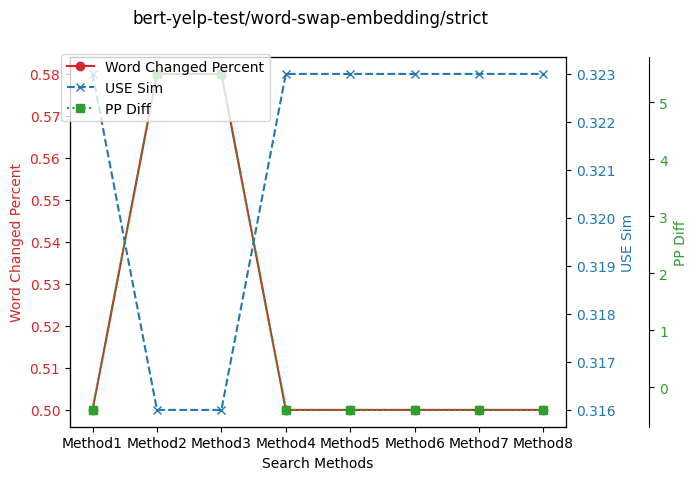

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
models = ["bert-yelp-test"]
transformations = ["word-swap-embedding"]
constraint_levels = ["strict"]
search_methods = ["Method1", "Method2", "Method3", "Method4", "Method5", "Method6", "Method7", "Method8"]
word_changed_percent = [0.5, 0.58, 0.58, 0.5, 0.5, 0.5, 0.5, 0.5]
use_sim = [0.323, 0.316, 0.316, 0.323, 0.323, 0.323, 0.323, 0.323]
pp_diff = [-0.4, 5.5, 5.5, -0.4, -0.4, -0.4, -0.4, -0.4]

# Create figure and axis
fig, ax1 = plt.subplots()

# Plot Word Changed Percent
color = 'tab:red'
ax1.set_xlabel('Search Methods')
ax1.set_ylabel('Word Changed Percent', color=color)
ax1.plot(search_methods, word_changed_percent, color=color, marker='o', label='Word Changed Percent')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for USE Sim
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('USE Sim', color=color)
ax2.plot(search_methods, use_sim, color=color, marker='x', linestyle='--', label='USE Sim')
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for PP Diff
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('PP Diff', color=color)
ax3.plot(search_methods, pp_diff, color=color, marker='s', linestyle=':', label='PP Diff')
ax3.tick_params(axis='y', labelcolor=color)

# Add title and legends
fig.suptitle(f'{models[0]}/{transformations[0]}/{constraint_levels[0]}')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Save figure as JPEG
plt.savefig('bert-yelp-test-word-swap-embedding-strict.jpg', format='jpeg')

# Show plot
plt.show()
